In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd
import numpy as np



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [2]:
def convert_for_test_data(start_date_str,end_date_str,solar):
    
    #end_date_str = '30/11/2020 23:45:00'
# Convert start and end date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
    datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')
    solar['start_timestamp']=datetime_column
    
    #Change column names and the types of variables
    solar = solar.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
    solar = solar[solar.power_output != "NaN"]
    solar["power_output"] = pd.to_numeric(solar["power_output"])
    
    
    #index timestamp and sort the time for testing dataset
    solar = solar.set_index(pd.DatetimeIndex(solar['timestamp'])).drop(solar.columns[1], axis=1)
    solar = pd.merge(solar, weather, left_index=True, right_index=True)
    #solar = solar[pd.Timestamp('2020-11-01 10:00:00'):pd.Timestamp('2020-12-01 09:45:00')]
    return solar

In [3]:
def tab(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [4]:
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [5]:
nov_test=pd.read_csv("NOV_test_data.csv")
nov_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2020-11-01 10:00:00,77.6,10.1,327.0,1.0,NaN,27.6,31.90,7.95,8.26,7.69,5.13,23.01
1,1,2020-11-01 10:15:00,25.7,3.1,315.0,NaN,NaN,27.6,32.02,8.51,8.11,7.52,5.01,23.73
2,2,2020-11-01 10:30:00,25.7,5.3,315.0,NaN,NaN,25.6,32.14,9.07,7.95,7.35,4.89,24.45
3,3,2020-11-01 10:45:00,25.7,7.9,315.0,1.0,NaN,25.6,36.68,9.38,9.12,8.15,5.59,28.05
4,4,2020-11-01 11:00:00,25.7,10.5,315.0,NaN,NaN,28.6,41.22,9.68,10.29,8.96,6.29,31.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
2876,2876,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
2877,2877,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
2878,2878,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [6]:
weather=pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2010-01-01 10:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [7]:
final_test=pd.read_csv("finaltest.csv")
final_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2016-07-04 07:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-07-04 07:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016-07-04 08:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016-07-04 08:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016-07-04 08:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154661,154661,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
154662,154662,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
154663,154663,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
154664,154664,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [8]:
def column_value(data, solar_number):
    a=data[['Date',solar_number]]
    a=a.dropna()
    a['series_name']=solar_number
    a.rename(columns={'Date':'start_timestamp',solar_number:'series_value'}, inplace=True)
    columns = a.columns.tolist()
    columns[0], columns[1],columns[2] = columns[2], columns[0],columns[1]
    a= a[columns]
    return a




In [9]:
def train_data(start,data):
    data['start_timestamp'] = pd.to_datetime(data['start_timestamp'])

    start_date = start
    end_date = '2020-11-01 10:00:00'
    df=data
    solar_0_train = df[(df['start_timestamp'] >= start_date) & (df['start_timestamp'] <= end_date)]
    # print(subset_df)
    return solar_0_train

In [10]:
def train_split_mod(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data
# Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.

    # Create a table of the various scores.
    result=pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return result



In [11]:
def predic_value(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.
    return testing_predictions

# solar train data

In [12]:
solar_0_train=column_value(final_test,'Solar0')
solar_0_train=train_data('2020-04-26 00:00:00',solar_0_train)
solar_1_train=column_value(final_test,'Solar1')
solar_1_train=train_data('2018-12-31 23:00:00',solar_1_train)
solar_2_train=column_value(final_test,'Solar2')
solar_2_train=train_data('2019-06-06 00:00:00',solar_2_train)
solar_3_train=column_value(final_test,'Solar3')
solar_3_train=train_data('2019-06-06 00:00:00',solar_3_train)
solar_4_train=column_value(final_test,'Solar4')
solar_4_train=train_data('2019-06-06 00:00:00',solar_4_train)
solar_5_train=column_value(final_test,'Solar5')
solar_5_train=train_data('2019-01-15 23:00:00',solar_5_train)

In [13]:
solar_0_train = convert_for_test_data("2020-04-26 00:00:00",'2020-11-01 10:00:00',solar_0_train)
solar_1_train = convert_for_test_data("2018-12-31 23:00:00","2020-11-01 10:00:00",solar_1_train)
solar_2_train = convert_for_test_data("2019-06-06 00:00:00","2020-11-01 10:00:00",solar_2_train)
solar_3_train = convert_for_test_data("2019-06-06 00:00:00","2020-11-01 10:00:00",solar_3_train)
solar_4_train = convert_for_test_data("2019-06-06 00:00:00","2020-11-01 10:00:00",solar_4_train)
solar_5_train = convert_for_test_data("2019-01-15 23:00:00","2020-11-01 10:00:00",solar_5_train)

# solar test data

In [14]:
solar_0_test_1=column_value(nov_test,'Solar0')
solar_1_test_1=column_value(nov_test,'Solar1')
solar_2_test_1=column_value(nov_test,'Solar2')
solar_3_test_1=column_value(nov_test,'Solar3')
solar_4_test_1=column_value(nov_test,'Solar4')
solar_5_test_1=column_value(nov_test,'Solar5')

In [15]:
solar_0_test_1 = convert_for_test_data("2020-11-01 10:00:00",'2020-12-01 09:45:00',solar_0_test_1)
solar_1_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_1_test_1)
solar_2_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_2_test_1)
solar_3_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_3_test_1)
solar_4_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_4_test_1)
solar_5_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_5_test_1)

# solar 0

In [16]:
X_train=solar_0_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_0_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_0_train['power_output']
Y_test = solar_0_test_1['power_output']

In [17]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.726271,5.239400,3.021114
test,0.815606,6.980669,5.039377


In [18]:
solar_0=predic_value(X_train,X_test,Y_train,Y_test)
df0=tab(solar_0,solar_0_test_1)
df0

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,23.760657,31.90
1,2020-11-01 10:15:00,25.803013,32.02
2,2020-11-01 10:30:00,27.845369,32.14
3,2020-11-01 10:45:00,29.887725,36.68
4,2020-11-01 11:00:00,31.930080,41.22
...,...,...,...
2875,2020-12-01 08:45:00,6.769633,13.21
2876,2020-12-01 09:00:00,6.420496,8.24
2877,2020-12-01 09:15:00,5.795694,9.42
2878,2020-12-01 09:30:00,5.170892,7.63


In [19]:
df0.set_index('timestamp', inplace=True)

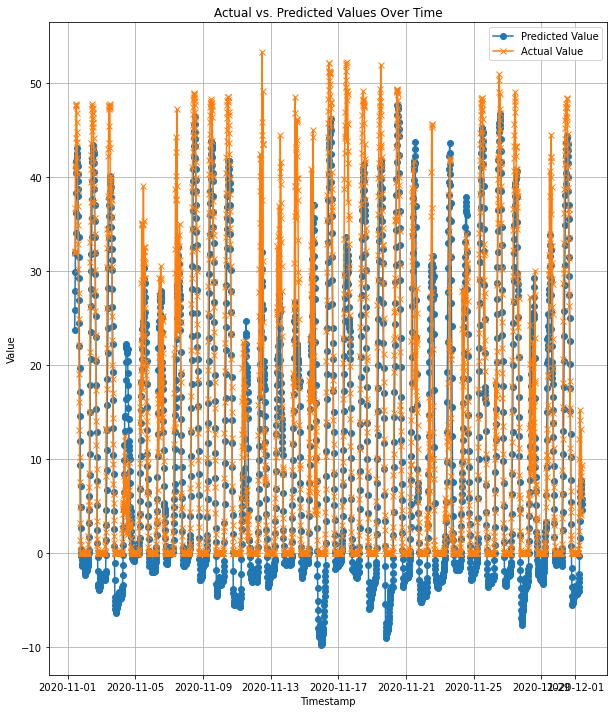

In [20]:
plt.figure(figsize=(10, 12))
plt.plot(df0.index, df0['Predicted'], label='Predicted Value', marker='o')
plt.plot(df0.index, df0['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# solar 1

In [21]:
X_train=solar_1_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_1_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_1_train['power_output']
Y_test = solar_1_test_1['power_output']

In [22]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.438120,2.583551,1.684739
test,0.790451,1.954042,1.335000


In [23]:
solar_1=predic_value(X_train,X_test,Y_train,Y_test)
df1=tab(solar_1,solar_1_test_1)
df1

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,5.104097,7.95
1,2020-11-01 10:15:00,5.541177,8.51
2,2020-11-01 10:30:00,5.978258,9.07
3,2020-11-01 10:45:00,6.415338,9.38
4,2020-11-01 11:00:00,6.852418,9.68
...,...,...,...
2875,2020-12-01 08:45:00,2.385355,2.32
2876,2020-12-01 09:00:00,2.303970,2.21
2877,2020-12-01 09:15:00,2.173309,2.00
2878,2020-12-01 09:30:00,2.042648,1.78


In [24]:
df1.set_index('timestamp', inplace=True)

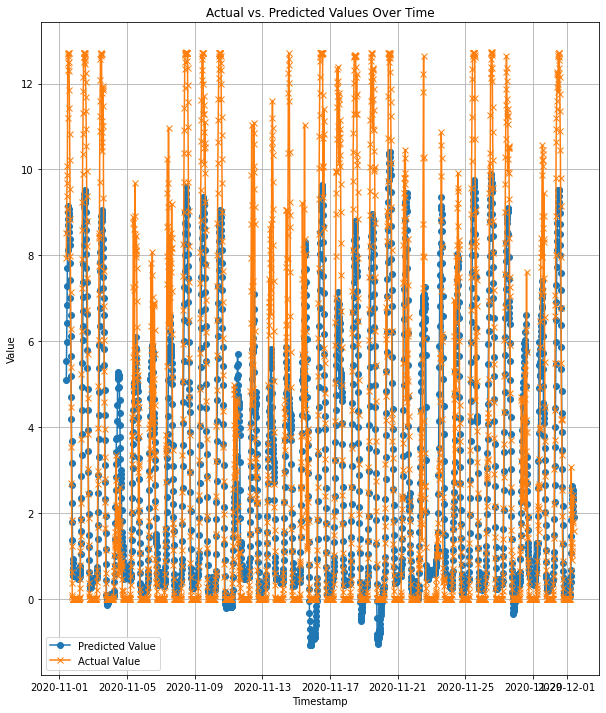

In [25]:
plt.figure(figsize=(10, 12))
plt.plot(df1.index, df1['Predicted'], label='Predicted Value', marker='o')
plt.plot(df1.index, df1['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# solar 2

In [26]:
X_train=solar_2_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_2_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_2_train['power_output']
Y_test = solar_2_test_1['power_output']

In [27]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.652294,1.861368,1.168177
test,0.835540,1.727233,1.127412


In [28]:
solar_2=predic_value(X_train,X_test,Y_train,Y_test)

df2=tab(solar_2,solar_2_test_1)
df2

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,5.710599,8.26
1,2020-11-01 10:15:00,6.181293,8.11
2,2020-11-01 10:30:00,6.651988,7.95
3,2020-11-01 10:45:00,7.122683,9.12
4,2020-11-01 11:00:00,7.593377,10.29
...,...,...,...
2875,2020-12-01 08:45:00,2.655735,2.21
2876,2020-12-01 09:00:00,2.576357,2.10
2877,2020-12-01 09:15:00,2.465240,1.90
2878,2020-12-01 09:30:00,2.354122,1.70


In [29]:
df2.set_index('timestamp', inplace=True)

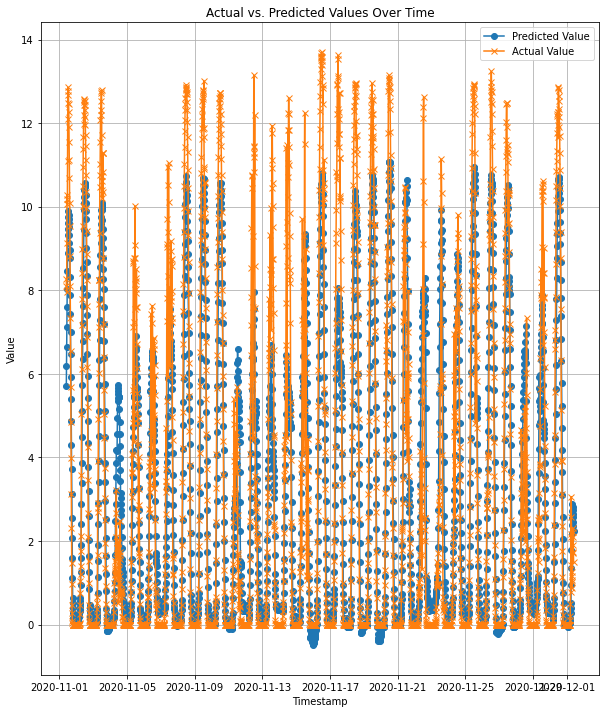

In [30]:
plt.figure(figsize=(10, 12))
plt.plot(df2.index, df2['Predicted'], label='Predicted Value', marker='o')
plt.plot(df2.index, df2['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# solar 3

In [31]:
X_train=solar_3_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_3_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_3_train['power_output']
Y_test = solar_3_test_1['power_output']

In [32]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.579187,1.490289,0.897511
test,0.724361,2.002209,1.272536


In [33]:
solar_3=predic_value(X_train,X_test,Y_train,Y_test)

df3=tab(solar_3,solar_3_test_1)
df3

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,4.181838,7.69
1,2020-11-01 10:15:00,4.494299,7.52
2,2020-11-01 10:30:00,4.806760,7.35
3,2020-11-01 10:45:00,5.119221,8.15
4,2020-11-01 11:00:00,5.431682,8.96
...,...,...,...
2875,2020-12-01 08:45:00,1.754640,3.11
2876,2020-12-01 09:00:00,1.727558,1.97
2877,2020-12-01 09:15:00,1.641097,2.24
2878,2020-12-01 09:30:00,1.554636,1.78


In [34]:
df3.set_index('timestamp', inplace=True)

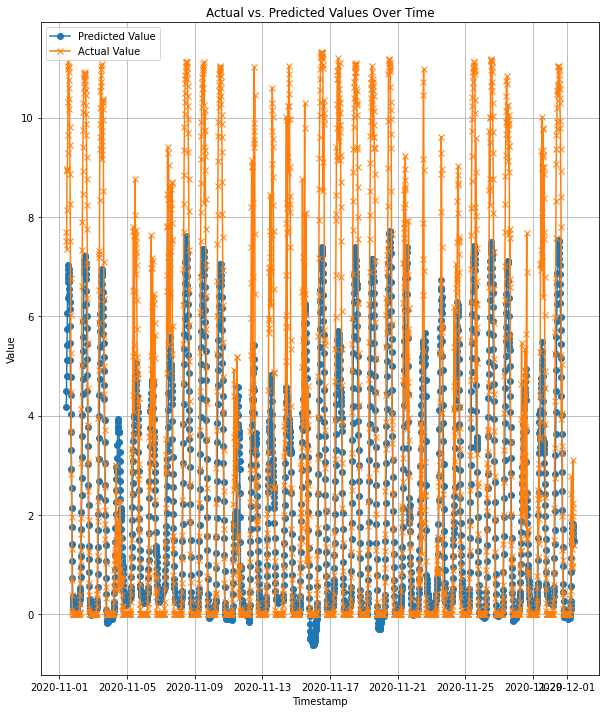

In [35]:
plt.figure(figsize=(10, 12))
plt.plot(df3.index, df3['Predicted'], label='Predicted Value', marker='o')
plt.plot(df3.index, df3['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# solar 4

In [36]:
X_train=solar_4_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_4_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_4_train['power_output']
Y_test = solar_4_test_1['power_output']

In [37]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.704496,1.038851,0.645285
test,0.828663,1.045717,0.678458


In [38]:
solar_4=predic_value(X_train,X_test,Y_train,Y_test)

df4=tab(solar_4,solar_4_test_1)
df4

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,3.557575,5.13
1,2020-11-01 10:15:00,3.849119,5.01
2,2020-11-01 10:30:00,4.140664,4.89
3,2020-11-01 10:45:00,4.432208,5.59
4,2020-11-01 11:00:00,4.723752,6.29
...,...,...,...
2875,2020-12-01 08:45:00,1.511067,1.31
2876,2020-12-01 09:00:00,1.464751,1.25
2877,2020-12-01 09:15:00,1.389192,1.13
2878,2020-12-01 09:30:00,1.313633,1.01


In [39]:
df4.set_index('timestamp', inplace=True)

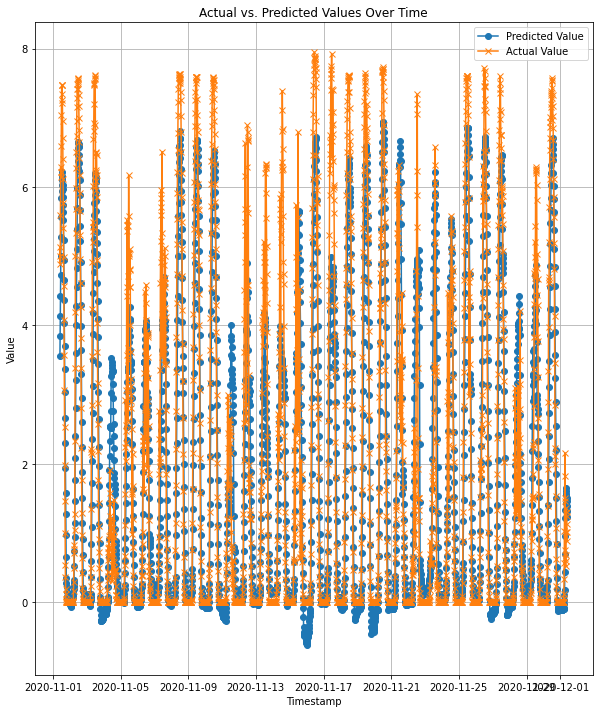

In [40]:
plt.figure(figsize=(10, 12))
plt.plot(df4.index, df4['Predicted'], label='Predicted Value', marker='o')
plt.plot(df4.index, df4['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# solar 5

In [41]:
X_train=solar_5_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_5_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_5_train['power_output']
Y_test = solar_5_test_1['power_output']

In [42]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.479779,6.427863,3.783254
test,0.688032,7.184029,4.626572


In [43]:
solar_5=predic_value(X_train,X_test,Y_train,Y_test)

df5=tab(solar_5,solar_5_test_1)
# df5.describe()
df5

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,13.256429,23.01
1,2020-11-01 10:15:00,14.453924,23.73
2,2020-11-01 10:30:00,15.651419,24.45
3,2020-11-01 10:45:00,16.848914,28.05
4,2020-11-01 11:00:00,18.046410,31.63
...,...,...,...
2875,2020-12-01 08:45:00,4.429118,9.86
2876,2020-12-01 09:00:00,4.227851,6.22
2877,2020-12-01 09:15:00,3.817892,7.14
2878,2020-12-01 09:30:00,3.407933,5.64


In [44]:
df5.set_index('timestamp', inplace=True)

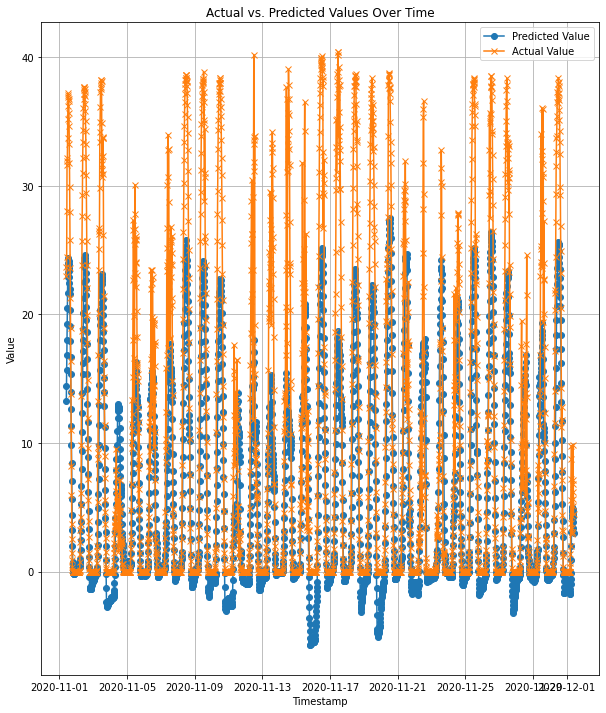

In [45]:

# print(gra)
plt.figure(figsize=(10, 12))
plt.plot(df5.index, df5['Predicted'], label='Predicted Value', marker='o')
plt.plot(df5.index, df5['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()